# Decision Modeling Mini Sprint 
This is a notebook to document the Decision Modeling Mini Sprint from IBM Skills Build. It is a 3-week sprint where we will analyze Formula 1 race data and build a decision model. To get started running this notebook, You can install the requirements by following the instructions in the [README.md](../README.md) file in the root of this repository.

## Problem Statement
We have been tasked with analyzing the data to make predictions on which constructor will win a head-to-head matchup on a specific circuit. We will use the data provided to build a decision model that will predict the points that each constructor will score in a head-to-head matchup on a specific circuit.

In [1]:
data_path = '../data/decision-modeling-sprint/'

In [2]:
zip_file = 'data.zip'
!unzip -o {data_path + zip_file} -d {data_path}

Archive:  ../data/decision-modeling-sprint/data.zip
  inflating: ../data/decision-modeling-sprint/circuits.csv  
  inflating: ../data/decision-modeling-sprint/constructor_results.csv  
  inflating: ../data/decision-modeling-sprint/constructor_standings.csv  
  inflating: ../data/decision-modeling-sprint/constructors.csv  
  inflating: ../data/decision-modeling-sprint/driver_standings.csv  
  inflating: ../data/decision-modeling-sprint/drivers.csv  
  inflating: ../data/decision-modeling-sprint/lap_times.csv  
  inflating: ../data/decision-modeling-sprint/pit_stops.csv  
  inflating: ../data/decision-modeling-sprint/qualifying.csv  
  inflating: ../data/decision-modeling-sprint/races.csv  
  inflating: ../data/decision-modeling-sprint/results.csv  
  inflating: ../data/decision-modeling-sprint/seasons.csv  
  inflating: ../data/decision-modeling-sprint/sprint_results.csv  
  inflating: ../data/decision-modeling-sprint/status.csv  


In [3]:
# Here we import all our libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api import types 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, normalize
pd.set_option('display.max_columns', None)

# Data Cleaning and Preprocessing

In [4]:
drivers = pd.read_csv(data_path + 'drivers.csv').replace('\\N', np.nan)
constructors = pd.read_csv(data_path + 'constructors.csv').replace('\\N', np.nan)
races = pd.read_csv(data_path + 'races.csv').replace('\\N', np.nan)
status = pd.read_csv(data_path + 'status.csv').replace('\\N', np.nan)
circuits = pd.read_csv(data_path + 'circuits.csv').replace('\\N', np.nan)

standings = pd.read_csv(data_path + 'driver_standings.csv').replace('\\N', np.nan)
constructor_standings = pd.read_csv(data_path + 'constructor_standings.csv').replace('\\N', np.nan)
qualifying = pd.read_csv(data_path + 'qualifying.csv').replace('\\N', np.nan)
results = pd.read_csv(data_path + 'results.csv').replace('\\N', np.nan)
sprint_results = pd.read_csv(data_path + 'sprint_results.csv').replace('\\N', np.nan)
constructor_results = pd.read_csv(data_path + 'constructor_results.csv').replace('\\N', np.nan)
lap_times = pd.read_csv(data_path + 'lap_times.csv').replace('\\N', np.nan)
pit_stops = pd.read_csv(data_path + 'pit_stops.csv').replace('\\N', np.nan)

In [5]:
constructors.info()
constructors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   constructorId   211 non-null    int64 
 1   constructorRef  211 non-null    object
 2   name            211 non-null    object
 3   nationality     211 non-null    object
 4   url             211 non-null    object
dtypes: int64(1), object(4)
memory usage: 8.4+ KB


,constructorId,constructorRef,name,nationality,url
0,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
1,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber
2,3,williams,Williams,British,http://en.wikipedia.org/wiki/Williams_Grand_Pr...
3,4,renault,Renault,French,http://en.wikipedia.org/wiki/Renault_in_Formul...
4,5,toro_rosso,Toro Rosso,Italian,http://en.wikipedia.org/wiki/Scuderia_Toro_Rosso


In [6]:
constructor_standings.info()
constructor_standings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13051 entries, 0 to 13050
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   constructorStandingsId  13051 non-null  int64  
 1   raceId                  13051 non-null  int64  
 2   constructorId           13051 non-null  int64  
 3   points                  13051 non-null  float64
 4   position                13051 non-null  int64  
 5   positionText            13051 non-null  object 
 6   wins                    13051 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 713.9+ KB


,constructorStandingsId,raceId,constructorId,points,position,positionText,wins
0,1,18,1,14.0,1,1,1
1,2,18,2,8.0,3,3,0
2,3,18,3,9.0,2,2,0
3,4,18,4,5.0,4,4,0
4,5,18,5,2.0,5,5,0


In [7]:
constructor_data = constructor_standings.merge(constructors[['name', 'constructorId']], on='constructorId')
constructor_data.drop(columns=['constructorStandingsId'], inplace=True)
constructor_data .rename(columns={'name': 'constructor'}, inplace=True)
constructor_data .head()

,raceId,constructorId,points,position,positionText,wins,constructor
0,18,1,14.0,1,1,1,McLaren
1,18,2,8.0,3,3,0,BMW Sauber
2,18,3,9.0,2,2,0,Williams
3,18,4,5.0,4,4,0,Renault
4,18,5,2.0,5,5,0,Toro Rosso


In [8]:
races.rename(columns={'name': 'raceName'}, inplace=True)
races = races.merge(circuits[['circuitId', 'name']], on='circuitId')
constructor_data  = constructor_data.merge(races[['raceId', 'year', 'round', 'name']], on='raceId')
constructor_data .rename(columns={'name': 'circuit', 'round': 'raceInSeason'}, inplace=True)
constructor_data .sort_values(by=['year', 'raceInSeason', 'points'], ascending=False, inplace=True)
constructor_data.rename(columns={'points': 'cumulativePoints', 'position':'endPosition'}, inplace=True)
constructor_data .head()

,raceId,constructorId,cumulativePoints,endPosition,positionText,wins,constructor,year,raceInSeason,circuit
13041,1110,9,503.0,1,1,12,Red Bull,2023,12,Circuit de Spa-Francorchamps
13044,1110,131,247.0,2,2,0,Mercedes,2023,12,Circuit de Spa-Francorchamps
13042,1110,117,196.0,3,3,0,Aston Martin,2023,12,Circuit de Spa-Francorchamps
13043,1110,6,191.0,4,4,0,Ferrari,2023,12,Circuit de Spa-Francorchamps
13050,1110,1,103.0,5,5,0,McLaren,2023,12,Circuit de Spa-Francorchamps


In [9]:
results.replace({'statusId': status.set_index('statusId')['status'].to_dict()}, inplace=True)
results.rename(columns={'statusId': 'status'}, inplace=True)
results.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,status
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,Finished
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,Finished
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,Finished
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,Finished
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,Finished


In [10]:
columns = ['raceId', 'driverId', 'constructorId', 'grid', 'laps', 'time', 'milliseconds', 'fastestLap', 'points', 'fastestLapTime', 'fastestLapSpeed', 'status']
constructor_data = constructor_data.merge(results[columns], on=['raceId', 'constructorId'])
constructor_data = constructor_data.merge(drivers[['driverId', 'driverRef']], on='driverId')
constructor_data.rename(columns={'points': 'racePoints', 'grid': 'startPosition'}, inplace=True)
constructor_data.head(10)

,raceId,constructorId,cumulativePoints,endPosition,positionText,wins,constructor,year,raceInSeason,circuit,driverId,startPosition,laps,time,milliseconds,fastestLap,racePoints,fastestLapTime,fastestLapSpeed,status,driverRef
0,1110,9,503.0,1,1,12,Red Bull,2023,12,Circuit de Spa-Francorchamps,830,6,44,1:22:30.450,4950450,32,25.0,1:48.922,231.490,Finished,max_verstappen
1,1110,9,503.0,1,1,12,Red Bull,2023,12,Circuit de Spa-Francorchamps,815,2,44,+22.305,4972755,31,18.0,1:50.308,228.581,Finished,perez
2,1110,131,247.0,2,2,0,Mercedes,2023,12,Circuit de Spa-Francorchamps,1,3,44,+49.671,5000121,44,13.0,1:47.305,234.978,Finished,hamilton
3,1110,131,247.0,2,2,0,Mercedes,2023,12,Circuit de Spa-Francorchamps,847,8,44,+1:03.101,5013551,25,8.0,1:50.603,227.972,Finished,russell
4,1110,117,196.0,3,3,0,Aston Martin,2023,12,Circuit de Spa-Francorchamps,4,9,44,+56.184,5006634,42,10.0,1:50.938,227.283,Finished,alonso
5,1110,117,196.0,3,3,0,Aston Martin,2023,12,Circuit de Spa-Francorchamps,840,10,44,+1:19.340,5029790,26,2.0,1:51.297,226.550,Finished,stroll
6,1110,6,191.0,4,4,0,Ferrari,2023,12,Circuit de Spa-Francorchamps,844,1,44,+32.259,4982709,30,15.0,1:50.436,228.316,Finished,leclerc
7,1110,6,191.0,4,4,0,Ferrari,2023,12,Circuit de Spa-Francorchamps,832,4,23,NaN,NaN,9,0.0,1:53.138,222.864,Collision damage,sainz
8,1110,1,103.0,5,5,0,McLaren,2023,12,Circuit de Spa-Francorchamps,846,7,44,+1:13.719,5024169,26,6.0,1:51.682,225.769,Finished,norris
9,1110,1,103.0,5,5,0,McLaren,2023,12,Circuit de Spa-Francorchamps,857,5,0,NaN,NaN,NaN,0.0,NaN,NaN,Collision damage,piastri


In [11]:
total_stop_time = pit_stops.groupby(['raceId', 'driverId'])['milliseconds'].sum().reset_index()
total_stop_time.rename(columns={'milliseconds': 'totalPitStopTime'}, inplace=True)
constructor_data = constructor_data.merge(total_stop_time, on=['raceId', 'driverId'], how='left')
constructor_data.head(10)

,raceId,constructorId,cumulativePoints,endPosition,positionText,wins,constructor,year,raceInSeason,circuit,driverId,startPosition,laps,time,milliseconds,fastestLap,racePoints,fastestLapTime,fastestLapSpeed,status,driverRef,totalPitStopTime
0,1110,9,503.0,1,1,12,Red Bull,2023,12,Circuit de Spa-Francorchamps,830,6,44,1:22:30.450,4950450,32,25.0,1:48.922,231.490,Finished,max_verstappen,45899.0
1,1110,9,503.0,1,1,12,Red Bull,2023,12,Circuit de Spa-Francorchamps,815,2,44,+22.305,4972755,31,18.0,1:50.308,228.581,Finished,perez,46394.0
2,1110,131,247.0,2,2,0,Mercedes,2023,12,Circuit de Spa-Francorchamps,1,3,44,+49.671,5000121,44,13.0,1:47.305,234.978,Finished,hamilton,69269.0
3,1110,131,247.0,2,2,0,Mercedes,2023,12,Circuit de Spa-Francorchamps,847,8,44,+1:03.101,5013551,25,8.0,1:50.603,227.972,Finished,russell,23837.0
4,1110,117,196.0,3,3,0,Aston Martin,2023,12,Circuit de Spa-Francorchamps,4,9,44,+56.184,5006634,42,10.0,1:50.938,227.283,Finished,alonso,46883.0
5,1110,117,196.0,3,3,0,Aston Martin,2023,12,Circuit de Spa-Francorchamps,840,10,44,+1:19.340,5029790,26,2.0,1:51.297,226.550,Finished,stroll,25397.0
6,1110,6,191.0,4,4,0,Ferrari,2023,12,Circuit de Spa-Francorchamps,844,1,44,+32.259,4982709,30,15.0,1:50.436,228.316,Finished,leclerc,46372.0
7,1110,6,191.0,4,4,0,Ferrari,2023,12,Circuit de Spa-Francorchamps,832,4,23,NaN,NaN,9,0.0,1:53.138,222.864,Collision damage,sainz,23303.0
8,1110,1,103.0,5,5,0,McLaren,2023,12,Circuit de Spa-Francorchamps,846,7,44,+1:13.719,5024169,26,6.0,1:51.682,225.769,Finished,norris,48756.0
9,1110,1,103.0,5,5,0,McLaren,2023,12,Circuit de Spa-Francorchamps,857,5,0,NaN,NaN,NaN,0.0,NaN,NaN,Collision damage,piastri,NaN


In [12]:
constructor_group = constructor_data.groupby(['constructorId', 'raceId', 'year'])['totalPitStopTime'].sum().reset_index()
constructor_group.rename(columns={'totalPitStopTime': 'constructorPitStopTime'}, inplace=True)
constructor_data = constructor_data.merge(constructor_group, on=['constructorId', 'raceId', 'year'])
constructor_data.head(10)

,raceId,constructorId,cumulativePoints,endPosition,positionText,wins,constructor,year,raceInSeason,circuit,driverId,startPosition,laps,time,milliseconds,fastestLap,racePoints,fastestLapTime,fastestLapSpeed,status,driverRef,totalPitStopTime,constructorPitStopTime
0,1110,9,503.0,1,1,12,Red Bull,2023,12,Circuit de Spa-Francorchamps,830,6,44,1:22:30.450,4950450,32,25.0,1:48.922,231.490,Finished,max_verstappen,45899.0,92293.0
1,1110,9,503.0,1,1,12,Red Bull,2023,12,Circuit de Spa-Francorchamps,815,2,44,+22.305,4972755,31,18.0,1:50.308,228.581,Finished,perez,46394.0,92293.0
2,1110,131,247.0,2,2,0,Mercedes,2023,12,Circuit de Spa-Francorchamps,1,3,44,+49.671,5000121,44,13.0,1:47.305,234.978,Finished,hamilton,69269.0,93106.0
3,1110,131,247.0,2,2,0,Mercedes,2023,12,Circuit de Spa-Francorchamps,847,8,44,+1:03.101,5013551,25,8.0,1:50.603,227.972,Finished,russell,23837.0,93106.0
4,1110,117,196.0,3,3,0,Aston Martin,2023,12,Circuit de Spa-Francorchamps,4,9,44,+56.184,5006634,42,10.0,1:50.938,227.283,Finished,alonso,46883.0,72280.0
5,1110,117,196.0,3,3,0,Aston Martin,2023,12,Circuit de Spa-Francorchamps,840,10,44,+1:19.340,5029790,26,2.0,1:51.297,226.550,Finished,stroll,25397.0,72280.0
6,1110,6,191.0,4,4,0,Ferrari,2023,12,Circuit de Spa-Francorchamps,844,1,44,+32.259,4982709,30,15.0,1:50.436,228.316,Finished,leclerc,46372.0,69675.0
7,1110,6,191.0,4,4,0,Ferrari,2023,12,Circuit de Spa-Francorchamps,832,4,23,NaN,NaN,9,0.0,1:53.138,222.864,Collision damage,sainz,23303.0,69675.0
8,1110,1,103.0,5,5,0,McLaren,2023,12,Circuit de Spa-Francorchamps,846,7,44,+1:13.719,5024169,26,6.0,1:51.682,225.769,Finished,norris,48756.0,48756.0
9,1110,1,103.0,5,5,0,McLaren,2023,12,Circuit de Spa-Francorchamps,857,5,0,NaN,NaN,NaN,0.0,NaN,NaN,Collision damage,piastri,NaN,48756.0


In [13]:
def convert_qualifying_time_to_ms(qualifying_time):
    try:
        minutes, remaining_time = str(qualifying_time).split('\n')[0].split(":")
        seconds = int(float(remaining_time))
        milliseconds = int(float(remaining_time) * 1000 % 1000) # Extract and convert to ms
        total_ms = (int(minutes) * 60000) + (int(seconds) * 1000) + int(milliseconds)
        return total_ms
    except ValueError:
        return None  # Handle invalid time formats

qualifying['q1'] = qualifying['q1'].apply(convert_qualifying_time_to_ms)
qualifying['q2'] = qualifying['q2'].apply(convert_qualifying_time_to_ms)
qualifying['q3'] = qualifying['q3'].apply(convert_qualifying_time_to_ms)
qualifying['averageQualifyingTime'] = qualifying[['q1', 'q2', 'q3']].mean(axis=1)
# limit to 3 decimal places
qualifying['averageQualifyingTime'] = qualifying['averageQualifyingTime'].apply(lambda x: round(x, 2))
qualifying.head(10)

,qualifyId,raceId,driverId,constructorId,number,position,q1,q2,q3,averageQualifyingTime
0,1,18,1,1,22,1,86572.0,85187.0,86714.0,86157.67
1,2,18,9,2,4,2,86103.0,85315.0,86869.0,86095.67
2,3,18,5,1,23,3,85664.0,85452.0,87079.0,86065.00
3,4,18,13,6,2,4,85994.0,85691.0,87178.0,86287.67
4,5,18,2,2,3,5,85960.0,85518.0,87236.0,86238.00
5,6,18,15,7,11,6,86427.0,86101.0,88527.0,87018.33
6,7,18,3,3,7,7,86295.0,86059.0,88687.0,87013.67
7,8,18,14,9,9,8,86381.0,86063.0,89041.0,87161.67
8,9,18,10,7,12,9,86919.0,86164.0,89593.0,87558.67
9,10,18,20,5,15,10,86702.0,85842.0,NaN,86272.00


In [14]:
constructor_data = constructor_data.merge(qualifying[['raceId', 'driverId', 'averageQualifyingTime']], on=['raceId', 'driverId'])
constructor_data.head(10)

,raceId,constructorId,cumulativePoints,endPosition,positionText,wins,constructor,year,raceInSeason,circuit,driverId,startPosition,laps,time,milliseconds,fastestLap,racePoints,fastestLapTime,fastestLapSpeed,status,driverRef,totalPitStopTime,constructorPitStopTime,averageQualifyingTime
0,1110,9,503.0,1,1,12,Red Bull,2023,12,Circuit de Spa-Francorchamps,830,6,44,1:22:30.450,4950450,32,25.0,1:48.922,231.490,Finished,max_verstappen,45899.0,92293.0,112489.00
1,1110,9,503.0,1,1,12,Red Bull,2023,12,Circuit de Spa-Francorchamps,815,2,44,+22.305,4972755,31,18.0,1:50.308,228.581,Finished,perez,46394.0,92293.0,112765.67
2,1110,131,247.0,2,2,0,Mercedes,2023,12,Circuit de Spa-Francorchamps,1,3,44,+49.671,5000121,44,13.0,1:47.305,234.978,Finished,hamilton,69269.0,93106.0,112665.00
3,1110,131,247.0,2,2,0,Mercedes,2023,12,Circuit de Spa-Francorchamps,847,8,44,+1:03.101,5013551,25,8.0,1:50.603,227.972,Finished,russell,23837.0,93106.0,113148.33
4,1110,117,196.0,3,3,0,Aston Martin,2023,12,Circuit de Spa-Francorchamps,4,9,44,+56.184,5006634,42,10.0,1:50.938,227.283,Finished,alonso,46883.0,72280.0,113142.67
5,1110,117,196.0,3,3,0,Aston Martin,2023,12,Circuit de Spa-Francorchamps,840,10,44,+1:19.340,5029790,26,2.0,1:51.297,226.550,Finished,stroll,25397.0,72280.0,113565.67
6,1110,6,191.0,4,4,0,Ferrari,2023,12,Circuit de Spa-Francorchamps,844,1,44,+32.259,4982709,30,15.0,1:50.436,228.316,Finished,leclerc,46372.0,69675.0,112435.00
7,1110,6,191.0,4,4,0,Ferrari,2023,12,Circuit de Spa-Francorchamps,832,4,23,NaN,NaN,9,0.0,1:53.138,222.864,Collision damage,sainz,23303.0,69675.0,112517.00
8,1110,1,103.0,5,5,0,McLaren,2023,12,Circuit de Spa-Francorchamps,846,7,44,+1:13.719,5024169,26,6.0,1:51.682,225.769,Finished,norris,48756.0,48756.0,113300.67
9,1110,1,103.0,5,5,0,McLaren,2023,12,Circuit de Spa-Francorchamps,857,5,0,NaN,NaN,NaN,0.0,NaN,NaN,Collision damage,piastri,NaN,48756.0,112590.33


In [15]:
constructor_data.drop(columns=['time', 'fastestLap', 'fastestLapTime', 'fastestLapSpeed', 'positionText', 'status', 'driverId', 'driverRef', 'totalPitStopTime'], inplace=True)
constructor_data.rename(columns={'milliseconds': 'raceTime'}, inplace=True)
constructor_data.head(10)

,raceId,constructorId,cumulativePoints,endPosition,wins,constructor,year,raceInSeason,circuit,startPosition,laps,raceTime,racePoints,constructorPitStopTime,averageQualifyingTime
0,1110,9,503.0,1,12,Red Bull,2023,12,Circuit de Spa-Francorchamps,6,44,4950450,25.0,92293.0,112489.00
1,1110,9,503.0,1,12,Red Bull,2023,12,Circuit de Spa-Francorchamps,2,44,4972755,18.0,92293.0,112765.67
2,1110,131,247.0,2,0,Mercedes,2023,12,Circuit de Spa-Francorchamps,3,44,5000121,13.0,93106.0,112665.00
3,1110,131,247.0,2,0,Mercedes,2023,12,Circuit de Spa-Francorchamps,8,44,5013551,8.0,93106.0,113148.33
4,1110,117,196.0,3,0,Aston Martin,2023,12,Circuit de Spa-Francorchamps,9,44,5006634,10.0,72280.0,113142.67
5,1110,117,196.0,3,0,Aston Martin,2023,12,Circuit de Spa-Francorchamps,10,44,5029790,2.0,72280.0,113565.67
6,1110,6,191.0,4,0,Ferrari,2023,12,Circuit de Spa-Francorchamps,1,44,4982709,15.0,69675.0,112435.00
7,1110,6,191.0,4,0,Ferrari,2023,12,Circuit de Spa-Francorchamps,4,23,NaN,0.0,69675.0,112517.00
8,1110,1,103.0,5,0,McLaren,2023,12,Circuit de Spa-Francorchamps,7,44,5024169,6.0,48756.0,113300.67
9,1110,1,103.0,5,0,McLaren,2023,12,Circuit de Spa-Francorchamps,5,0,NaN,0.0,48756.0,112590.33


In [16]:
constructor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9720 entries, 0 to 9719
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   raceId                  9720 non-null   int64  
 1   constructorId           9720 non-null   int64  
 2   cumulativePoints        9720 non-null   float64
 3   endPosition             9720 non-null   int64  
 4   wins                    9720 non-null   int64  
 5   constructor             9720 non-null   object 
 6   year                    9720 non-null   int64  
 7   raceInSeason            9720 non-null   int64  
 8   circuit                 9720 non-null   object 
 9   startPosition           9720 non-null   int64  
 10  laps                    9720 non-null   int64  
 11  raceTime                4285 non-null   object 
 12  racePoints              9720 non-null   float64
 13  constructorPitStopTime  9720 non-null   float64
 14  averageQualifyingTime   9573 non-null   

In [17]:
constructor_data = constructor_data[constructor_data['year'] >= 2013]

In [18]:
import sys

constructor_data['laps'] = constructor_data.groupby(['constructorId', 'raceId'])['laps'].transform('sum')
constructor_data['startPosition'] = constructor_data.groupby(['constructorId', 'raceId'])['startPosition'].transform('min')
constructor_data['racePoints'] = constructor_data.groupby(['constructorId', 'raceId'])['racePoints'].transform('sum')
constructor_data.fillna({'raceTime': sys.maxsize}, inplace=True)
constructor_data['raceTime'] = constructor_data['raceTime'].astype(int)
constructor_data['raceTime'] = constructor_data.groupby(['constructorId', 'raceId'])['raceTime'].transform('min')
constructor_data['averageQualifyingTime'] = constructor_data.groupby(['constructorId', 'raceId'])['averageQualifyingTime'].transform('min')
constructor_data.rename(columns={'averageQualifyingTime': 'minQualifyingAvgTime'}, inplace=True)
constructor_data.head(10)

,raceId,constructorId,cumulativePoints,endPosition,wins,constructor,year,raceInSeason,circuit,startPosition,laps,raceTime,racePoints,constructorPitStopTime,minQualifyingAvgTime
0,1110,9,503.0,1,12,Red Bull,2023,12,Circuit de Spa-Francorchamps,2,88,4950450,43.0,92293.0,112489.00
1,1110,9,503.0,1,12,Red Bull,2023,12,Circuit de Spa-Francorchamps,2,88,4950450,43.0,92293.0,112489.00
2,1110,131,247.0,2,0,Mercedes,2023,12,Circuit de Spa-Francorchamps,3,88,5000121,21.0,93106.0,112665.00
3,1110,131,247.0,2,0,Mercedes,2023,12,Circuit de Spa-Francorchamps,3,88,5000121,21.0,93106.0,112665.00
4,1110,117,196.0,3,0,Aston Martin,2023,12,Circuit de Spa-Francorchamps,9,88,5006634,12.0,72280.0,113142.67
5,1110,117,196.0,3,0,Aston Martin,2023,12,Circuit de Spa-Francorchamps,9,88,5006634,12.0,72280.0,113142.67
6,1110,6,191.0,4,0,Ferrari,2023,12,Circuit de Spa-Francorchamps,1,67,4982709,15.0,69675.0,112435.00
7,1110,6,191.0,4,0,Ferrari,2023,12,Circuit de Spa-Francorchamps,1,67,4982709,15.0,69675.0,112435.00
8,1110,1,103.0,5,0,McLaren,2023,12,Circuit de Spa-Francorchamps,5,44,5024169,6.0,48756.0,112590.33
9,1110,1,103.0,5,0,McLaren,2023,12,Circuit de Spa-Francorchamps,5,44,5024169,6.0,48756.0,112590.33


In [19]:
constructor_data[constructor_data['raceTime'] == sys.maxsize].head(20)

,raceId,constructorId,cumulativePoints,endPosition,wins,constructor,year,raceInSeason,circuit,startPosition,laps,raceTime,racePoints,constructorPitStopTime,minQualifyingAvgTime
30,1109,214,47.0,6,0,Alpine F1 Team,2023,11,Hungaroring,12,3,9223372036854775807,0.0,0.0,78347.50
31,1109,214,47.0,6,0,Alpine F1 Team,2023,11,Hungaroring,12,3,9223372036854775807,0.0,0.0,78347.50
32,1109,3,11.0,7,0,Williams,2023,11,Hungaroring,16,136,9223372036854775807,0.0,90036.0,78917.00
33,1109,3,11.0,7,0,Williams,2023,11,Hungaroring,16,136,9223372036854775807,0.0,90036.0,78917.00
34,1109,210,11.0,8,0,Haas F1 Team,2023,11,Hungaroring,10,138,9223372036854775807,0.0,89782.0,77844.33
35,1109,210,11.0,8,0,Haas F1 Team,2023,11,Hungaroring,10,138,9223372036854775807,0.0,89782.0,77844.33
36,1109,51,9.0,9,0,Alfa Romeo,2023,11,Hungaroring,5,138,9223372036854775807,0.0,97420.0,77604.67
37,1109,51,9.0,9,0,Alfa Romeo,2023,11,Hungaroring,5,138,9223372036854775807,0.0,97420.0,77604.67
38,1109,213,2.0,10,0,AlphaTauri,2023,11,Hungaroring,13,138,9223372036854775807,0.0,91512.0,78454.00
39,1109,213,2.0,10,0,AlphaTauri,2023,11,Hungaroring,13,138,9223372036854775807,0.0,91512.0,78454.00


In [20]:
constructor_data.drop(columns=['raceId', 'constructorId'], inplace=True)
constructor_data.drop_duplicates(inplace=True)
constructor_data.tail(10)

,cumulativePoints,endPosition,wins,constructor,year,raceInSeason,circuit,startPosition,laps,raceTime,racePoints,constructorPitStopTime,minQualifyingAvgTime
4329,26.0,2,1,Lotus F1,2013,1,Albert Park Grand Prix Circuit,7,116,5403225,26.0,111796.0,96979.33
4331,23.0,3,0,Red Bull,2013,1,Albert Park Grand Prix Circuit,1,116,5425571,23.0,133579.0,96269.67
4333,10.0,4,0,Mercedes,2013,1,Albert Park Grand Prix Circuit,3,84,5448786,10.0,88222.0,96032.33
4335,10.0,5,0,Force India,2013,1,Albert Park Grand Prix Circuit,9,116,5468293,10.0,91503.0,97269.00
4337,2.0,6,0,McLaren,2013,1,Albert Park Grand Prix Circuit,10,116,5484855,2.0,134777.0,97229.67
4339,0.0,7,0,Toro Rosso,2013,1,Albert Park Grand Prix Circuit,13,97,5487082,0.0,118534.0,101824.50
4341,0.0,8,0,Sauber,2013,1,Albert Park Grand Prix Circuit,11,57,9223372036854775807,0.0,44631.0,101998.50
4343,0.0,9,0,Williams,2013,1,Albert Park Grand Prix Circuit,16,81,9223372036854775807,0.0,93902.0,103809.00
4345,0.0,10,0,Marussia,2013,1,Albert Park Grand Prix Circuit,19,113,9223372036854775807,0.0,159777.0,108147.00
4347,0.0,11,0,Caterham,2013,1,Albert Park Grand Prix Circuit,21,112,9223372036854775807,0.0,118758.0,109519.00


In [21]:
analysis_data = constructor_data.copy()
training_data = constructor_data.copy()

# Data Analysis


In [22]:
# Create embeddings for non numerical data
label_encoders = {}
for column in ['constructor', 'circuit']:
    le = LabelEncoder()
    analysis_data[column] = le.fit_transform(analysis_data[column])
    label_encoders[column] = le

analysis_data.head()

,cumulativePoints,endPosition,wins,constructor,year,raceInSeason,circuit,startPosition,laps,raceTime,racePoints,constructorPitStopTime,minQualifyingAvgTime
0,503.0,1,12,14,2023,12,15,2,88,4950450,43.0,92293.0,112489.00
2,247.0,2,0,12,2023,12,15,3,88,5000121,21.0,93106.0,112665.00
4,196.0,3,0,3,2023,12,15,9,88,5006634,12.0,72280.0,113142.67
6,191.0,4,0,5,2023,12,15,1,67,4982709,15.0,69675.0,112435.00
8,103.0,5,0,11,2023,12,15,5,44,5024169,6.0,48756.0,112590.33


In [23]:
analysis_data.describe()

,cumulativePoints,endPosition,wins,constructor,year,raceInSeason,circuit,startPosition,laps,raceTime,racePoints,constructorPitStopTime,minQualifyingAvgTime
count,2182.000000,2182.000000,2182.000000,2182.000000,2182.000000,2182.000000,2182.000000,2182.000000,2182.000000,2.182000e+03,2182.000000,2.182000e+03,2182.000000
mean,102.821494,5.638405,1.011457,10.313474,2017.818515,10.358387,16.535747,8.614115,106.708066,3.364713e+18,9.903529,3.257754e+05,88113.079551
std,141.958491,2.965931,2.664893,5.404228,3.074509,5.846961,9.840887,5.568344,29.468010,4.440917e+18,12.621050,9.362387e+05,13124.277224
min,0.000000,1.000000,0.000000,0.000000,2013.000000,1.000000,0.000000,0.000000,0.000000,2.070710e+05,0.000000,0.000000e+00,53694.670000
25%,8.000000,3.000000,0.000000,6.000000,2015.000000,5.000000,8.000000,4.000000,93.000000,5.584246e+06,0.000000,5.301425e+04,77861.667500
50%,42.000000,6.000000,0.000000,11.000000,2018.000000,10.000000,15.000000,8.000000,110.000000,6.241536e+06,4.000000,8.899800e+04,87993.915000
75%,134.000000,8.000000,0.000000,15.000000,2021.000000,15.000000,26.000000,13.000000,130.000000,9.223372e+18,15.750000,1.230048e+05,96884.252500
max,765.000000,11.000000,19.000000,18.000000,2023.000000,22.000000,32.000000,21.000000,174.000000,9.223372e+18,66.000000,7.364776e+06,133469.000000


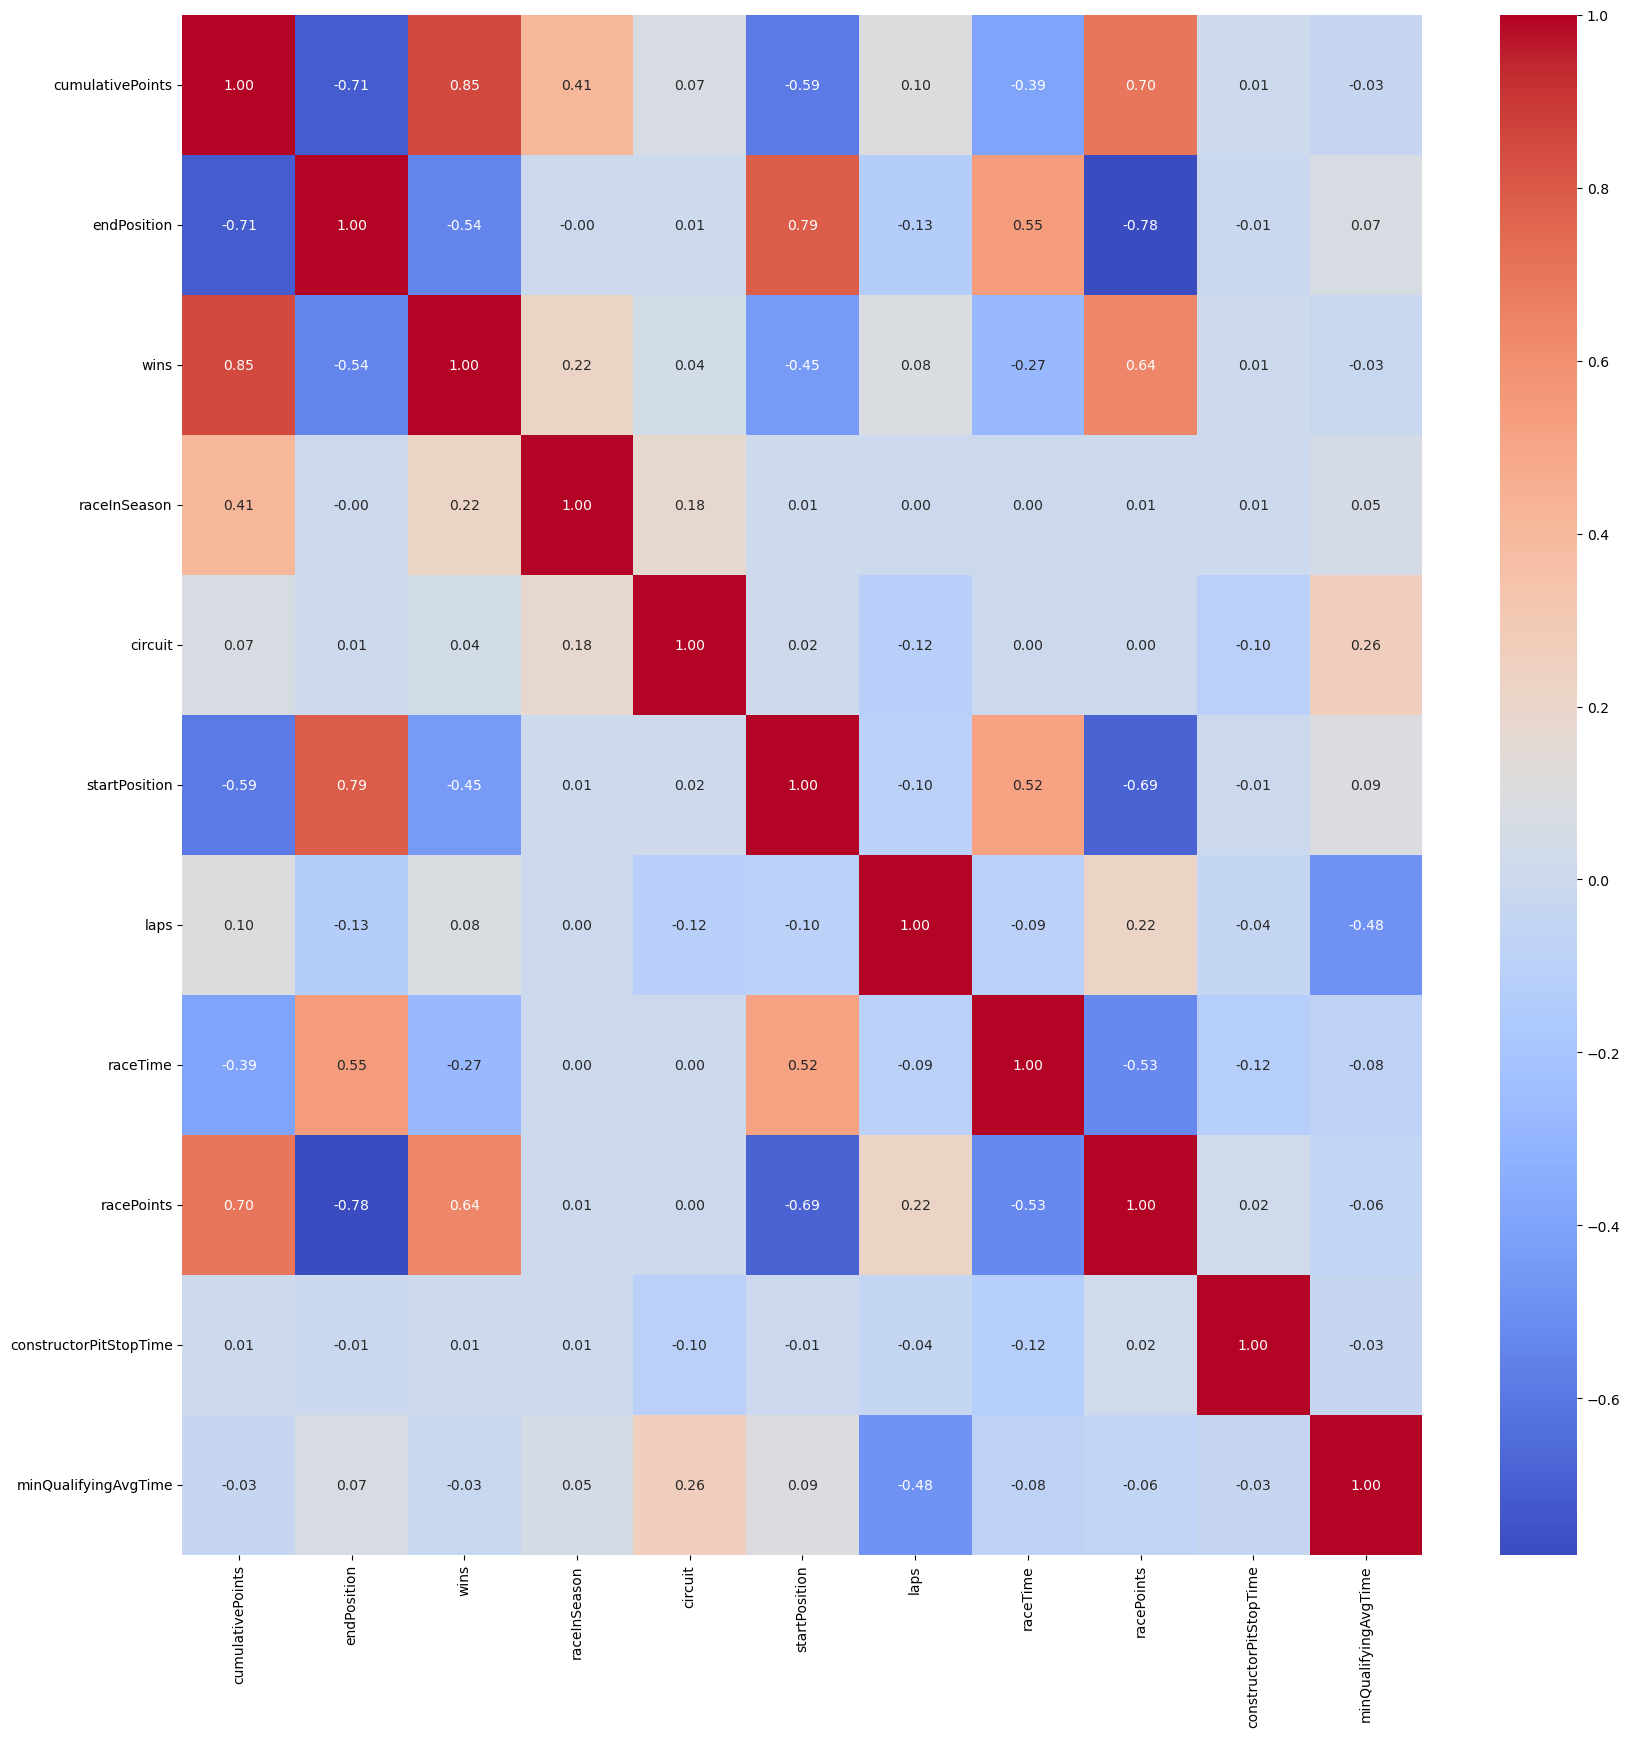

In [24]:
corr = analysis_data.drop(columns=['year', 'constructor', ]).corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"size": 10})
plt.show()

## Different Correlations to Explore

- Correlation between points scored by the constructor and the circuit
- Correlation between points scored by the constructor and the year
- Correlation between points scored by the constructor and the race number
- Correlation between points scored by the constructor and pit stop time
- Correlation between points scored by the constructor and qualifying time
- Correlation between points scored by the constructor and the number of laps completed

# Decision Model